# Using USD imaging features within Google Colab

This Google Colab notebook demonstrates USD's imaging features within Google Colab to render a scene.

## Build and install USD

In [ ]:
%%shell

# Install GLEW (required to build USD < v21.02):
apt install libglew-dev

# Install Python dependencies:
pip install PySide2

# Fetch USD sources.
#
# See https://github.com/PixarAnimationStudios/USD/releases for the list of
# available releases. Note that not all USD releases will be compatible with
# `arnold-usd`, or the Python version available in Google Colab (3.9, as of
# February 2021).
git clone https://github.com/PixarAnimationStudios/USD.git --branch "v20.08"

# Build USD:
python USD/build_scripts/build_usd.py \
    --embree \
    --no-docs \
    --no-examples \
    --no-tutorials \
    --no-usdview \
    "usd_install_dir"

In [2]:
import os
import sys

if '/content/usd_install_dir/bin:/content/usd_install_dir/lib' not in os.environ['PATH']:
    os.environ['PATH'] = '/content/usd_install_dir/bin:' + os.environ['PATH']
if '/content/usd_install_dir/lib/python' not in sys.path:
    sys.path.insert(0, '/content/usd_install_dir/lib/python')

In [ ]:
%set_env PATH = /content/usd_install_dir/bin:/content/usd_install_dir/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin
%set_env PYTHONPATH = /content/usd_install_dir/lib/python:/env/python

In [ ]:
%%shell

pip install PyVirtualDisplay
apt install xvfb
apt-get upgrade mesa-common-dev libgl1-mesa-dev libglu1-mesa-dev

# Build Autodesk's `arnold-usd`

In [ ]:
! git clone https://github.com/Autodesk/arnold-usd.git --branch "arnold-6.2.0.0"

In [ ]:
! curl https://wdown.solidangle.com/arnold/Arnold-6.1.0.1-linux.tgz \
    --output arnold-sdk.tgz
! mkdir -p /content/arnold-sdk
! tar -xvzf arnold-sdk.tgz -C /content/arnold-sdk

In [ ]:
! mkdir -p /content/arnold-usd/build
%cd /content/arnold-usd/build

! cmake .. \
    -DCMAKE_BUILD_TYPE=Release \
    -DARNOLD_LOCATION=/content/arnold-sdk \
    -DUSD_LOCATION=/content/usd_install_dir \
    -DTBB_FOUND=ON \
    -DTBB_INCLUDE_DIRS=/content/usd_install_dir/include \
    -DTBB_LIBRARIES=/content/usd_install_dir/lib/libtbb.so \
    -DBUILD_UNIT_TESTS=OFF \
    -DCMAKE_CXX_STANDARD=14 \
    -DCMAKE_INSTALL_PREFIX=/content/arnold-usd/install \
    -DBUILD_SHARED_LIBS=ON \
    -DBUILD_SCHEMAS=OFF \
    -DBUILD_TESTSUITE=OFF \
    -DBUILD_DOCS=OFF \
    \
    -DBoost_INCLUDE_DIRS=/content/usd_install_dir/include \
    -DBoost_LIBRARIES=/content/usd_install_dir/lib/libboost_python36.so

! mkdir -p /content/arnold-usd/build/install
%cd /content/arnold-usd/build
! make
! make install

%cd /content

In [ ]:
%set_env ARNOLD_PLUGIN_PATH = /content/arnold-usd/install/procedural
%set_env PXR_PLUGINPATH_NAME = /content/arnold-usd/install/plugin
%set_env LD_LIBRARY_PATH = /usr/lib64-nvidia:/content/arnold-sdk/bin:/content/usd_install_dir/lib:/content/arnold-usd/install/plugin

In [ ]:
#@title Arnold render settings

#
# Arnold render delegate default values.
#
# Default values taken from https://github.com/Autodesk/arnold-usd/blob/d15f64082e622d3e2cd4705330726fabfdf7bc99/render_delegate/config.cpp#L39-L101
#

#@markdown #### Image bucket size (default: `24`)
#@markdown Bigger buckets use more memory, while smaller buckets may perform redundant computations and filtering and thus render slower but give initial faster feedback.
HDARNOLD_bucket_size = 64 #@param {type:"integer"}

# #@markdown Abort on error:
# HDARNOLD_abort_on_error = False #@param {type:"boolean"}

# #@markdown Control the amount of log output (`0`-`5`):
# HDARNOLD_log_verbosity = 2 #@param {type:"slider", min:0, max:5, step:1}

# #@markdown Set a filepath to output logging information to:
# HDARNOLD_log_file = '' #@param {type:"string"}

#@markdown #### Number of anti-aliasing (AA) samples by default (default: `10`):
#@markdown Supersampling control over the number of rays per pixel that will be traced from the camera. The higher the number of samples, the better the anti-aliasing quality, and the longer the render times. The exact number of rays per pixel is the square of this value. For example, a *Camera (AA)* samples value of 3 means 3x3 = 9-pixel samples. In practice, you may consider using a value of 4 for medium quality, 8 for high quality, and (rarely) 16 for super-high quality. This control acts as a global multiplier of all the different rays, multiplying the number of *diffuse* and *specular* rays. Motion blur and depth of field quality can only be improved by increasing *Camera (AA)* samples.
HDARNOLD_AA_samples =  7#@param {type:"integer"}

#@markdown #### Number of diffuse samples by default (default: `1`):
#@markdown Controls the number of rays fired when computing the reflected indirect-radiance integrated over the hemisphere. The exact number of hemispherical rays is the square of this value. Increase this number to reduce the indirect diffuse noise. Remember that the diffuse sampling is done for each *Camera (AA)* sample, so high values for both *Camera (AA)* samples and *diffuse* samples will tend to result in slow renders.
#@markdown
#@markdown When *diffuse* samples are more than zero, camera rays intersecting with diffuse surfaces fire indirect diffuse rays. The rays are fired in random directions within a hemispherical spread. Noise is introduced when there are insufficient rays to resolve the range of values from the environment.
HDARNOLD_GI_diffuse_samples = 1 #@param {type:"integer"}

#@markdown #### Number of specular samples by default (default: `1`):
#@markdown Controls the number of rays fired when computing the reflected indirect-radiance integrated over the hemisphere weighted by a specular BRDF. The exact number of rays is the square of this value. Increase this number to reduce the indirect specular noise (soft/blurry reflections). Remember that the specular sampling is done for each *Camera (AA)* sample, so high values for both *Camera (AA)* samples and specular samples will tend to result in slow renders.
HDARNOLD_GI_specular_samples = 1 #@param {type:"integer"}

#@markdown #### Number of transmission samples by default (default: `1`)
#@markdown Controls the number of samples used to simulate the microfacet-based transmission evaluations. Increase this value to resolve any noise in the transmission. If you switch this parameter to zero, the `GI_transmission_depth` to zero, and the noise disappears, you will know that the noise is due to transmission.
HDARNOLD_GI_transmission_samples = 1 #@param {type:"number"}

#@markdown #### Number of sub-surface scattering (SSS) samples by default (default: `1`):
#@markdown This value controls the number of lighting samples (direct and indirect) that will be taken to estimate lighting within a radius of the point being shaded to compute sub-surface scattering. Higher values produce a cleaner solution but will take longer to render.
HDARNOLD_GI_sss_samples = 1 #@param {type:"integer"}

#@markdown #### Number of volume samples by default (default: `1`):
#@markdown Controls the number of sample rays that get fired to compute indirect lighting of the volume. Like the other sampling rate controls (*Camera (AA)*, light samples, *diffuse* samples, etc.), the number of actual samples is squared, so a setting of 3 fires 3x3=9 rays. Setting it to 0 turns off the indirect lighting of the volume. Note that indirect volume lighting is tied to the 'Volume' ray depth render option, and therefore there must be at least 1 volume bounce for indirect lighting to be computed.
HDARNOLD_GI_volume_samples = 1 #@param {type:"integer"}

#@markdown #### Number of threads for CPU rendering by default (default: `-1`):
#@markdown **NOTE:** This is only applicable if `HDARNOLD_enable_gpu_rendering` is set to `True`.
#@markdown
#@markdown This lets you manually set the number of rendering threads. Negative numbers are also allowed. If specifying `0` threads means to use all cores on a machine, then negative numbers can mean use all but that many cores. For example, `threads=-2` means use all but two cores, while `threads=2` means only use two cores. This is useful when you want to leave one or two cores for other tasks. One example of this is so that the DCC application can be more responsive while Arnold is rendering in the Render View.
HDARNOLD_threads = 0 #@param {type:"integer"}

# #@markdown Diffuse ray depth by default (default: `1`):
# HDARNOLD_GI_diffuse_depth = 1 #@param {type:"number"}

# #@markdown Diffuse ray depth by default (default: `1`):
# HDARNOLD_GI_specular_depth = 1 #@param {type:"number"}

# #@markdown Enable progressive render (default: `True`):
# HDARNOLD_enable_progressive_render = False #@param {type:"boolean"}

# #@markdown Minimum AA samples for progressive rendering (default: `-4`):
# HDARNOLD_progressive_min_AA_samples = -4 #@param {type:"integer"}

# #@markdown Enable adaptive sampling (default: `False`):
# HDARNOLD_enable_adaptive_sampling = False #@param {type:"boolean"}

#@markdown #### Enable GPU rendering (default: `False`):
#@markdown Render using the GPU or CPU.
HDARNOLD_enable_gpu_rendering = False #@param {type:"boolean"}

# #@markdown Shutter start for the camera:
# HDARNOLD_shutter_start = -0.25 #@param {type:"number"}

# #@markdown Shutter end for the camera:
# HDARNOLD_shutter_end = 0.25 #@param {type:"number"}

# #@markdown Interactive target fps for progressive rendering:
# HDARNOLD_interactive_target_fps = 30.0 #@param {type:"number"}

# #@markdown Min interactive target fps for progressive rendering:
# HDARNOLD_interactive_target_fps_min = 20.0 #@param {type:"number"}

# #@markdown Minimum fps for progressive rendering:
# HDARNOLD_interactive_fps_min = 5.0 #@param {type:"number"}

# #@markdown Output file for profiling information:
# HDARNOLD_profile_file = '' #@param {type:"string"}

# #@markdown Texture search path:
# HDARNOLD_texture_searchpath = '' #@param {type:"string"}

# #@markdown Plugin search path:
# HDARNOLD_plugin_searchpath = '' #@param {type:"string"}

# #@markdown Procedural search path:
# HDARNOLD_procedural_searchpath = '' #@param {type:"string"}

# #@markdown OSL include path:
# HDARNOLD_osl_includepath = '' #@param {type:"string"}


%set_env HDARNOLD_bucket_size = $HDARNOLD_bucket_size
%set_env HDARNOLD_AA_samples = $HDARNOLD_AA_samples
%set_env HDARNOLD_GI_diffuse_samples = $HDARNOLD_GI_diffuse_samples
%set_env HDARNOLD_GI_specular_samples = $HDARNOLD_GI_specular_samples
%set_env HDARNOLD_GI_transmission_samples = $HDARNOLD_GI_transmission_samples
%set_env HDARNOLD_GI_sss_samples = $HDARNOLD_GI_sss_samples
%set_env HDARNOLD_GI_volume_samples = $HDARNOLD_GI_volume_samples
%set_env HDARNOLD_threads = $HDARNOLD_threads
# %set_env HDARNOLD_GI_diffuse_depth = $HDARNOLD_GI_diffuse_depth
# %set_env HDARNOLD_GI_specular_depth = $HDARNOLD_GI_specular_depth
# %set_env HDARNOLD_enable_progressive_render = $HDARNOLD_enable_progressive_render
# %set_env HDARNOLD_progressive_min_AA_samples = $HDARNOLD_progressive_min_AA_samples
# %set_env HDARNOLD_enable_adaptive_sampling = $HDARNOLD_enable_adaptive_sampling
%set_env HDARNOLD_enable_gpu_rendering = $HDARNOLD_enable_gpu_rendering


## **Optional:** Arnold license information

In case you have an Arnold license, you can enter it here. Otherwise, feel free to leave these settings blank.

In [ ]:
%set_env ARNOLD_LICENSE_ORDER = ''
%set_env ARNOLD_LICENSE_MANAGER = ''
%set_env solidangle_LICENSE = ''
%set_env RLM_LICENSE = ''
%set_env ADSKFLEX_LICENSE_FILE = ''
%set_env LM_LICENSE_FILE = ''

## Download Pixar's _Kitchen set_ sample

In [ ]:
%%shell

# Download and unzip Pixar's "Kitchen Set" USD sample scene:
mkdir -p usd_data/Kitchen_set
curl -L https://graphics.pixar.com/usd/files/Kitchen_set.zip \
    --output usd_data/Kitchen_set.zip
unzip usd_data/Kitchen_set.zip -d usd_data

## Render the scene

This will take a few seconds. Please hang on!

Rendering the USD scene...
Rendering completed in 83.59882855415344 seconds:


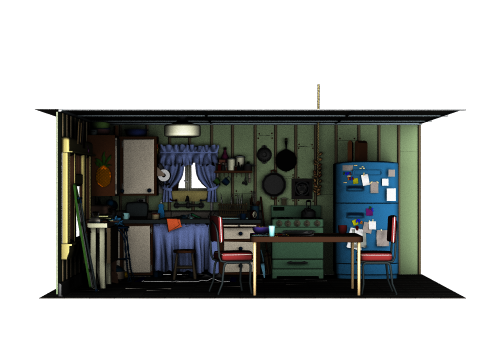

In [27]:
import time
from IPython.display import Image
from pyvirtualdisplay import Display

IMAGE_WIDTH = 700
IMAGE_FILENAME = 'kitchen_set-Arnold.png'

renderStartTime = time.time()
try:
    print('Rendering the USD scene...')
    display = Display(size=(IMAGE_WIDTH, IMAGE_WIDTH)).start()
    ! usdrecord \
        --imageWidth $IMAGE_WIDTH \
        --renderer Arnold \
        usd_data/Kitchen_set/Kitchen_set.usd \
        $IMAGE_FILENAME > /dev/null 2>&1
finally:
    display.stop()

print("Rendering completed in {timeElapsed} seconds:".format(
    timeElapsed=time.time() - renderStartTime
))
Image(IMAGE_FILENAME)

## Package the USD binaries for export

Build a ZIP archive containing the list of USD binaries produced from the build, so they can be saved externally and imported back into a notebook used for consumption later on.

In [ ]:
%%shell

zip -r usd-install.zip usd_install_dir/bin
zip -ur usd-install.zip usd_install_dir/lib
zip -ur usd-install.zip arnold-sdk/bin
zip -ur usd-install.zip arnold-usd/install/plugin

## Custom sphere sample

In [ ]:
%%file usd_data/sphere-sample.usda
#usda 1.0

/*
def Xform "Lights"
{
    def SphereLight "SphereLight"
    {
    }
}
*/

def Xform "Geometry"
{
    def Sphere "RedSphere"
    {
        color3f[] primvars:displayColor = [(1, 0, 0)]
    }

    def Sphere "BlueSphere"
    {
        color3f[] primvars:displayColor = [(0, 0, 1)]

        double3 xformOp:translate = (2, 0, 0)
        uniform token[] xformOpOrder = ["xformOp:translate"]
    }
}

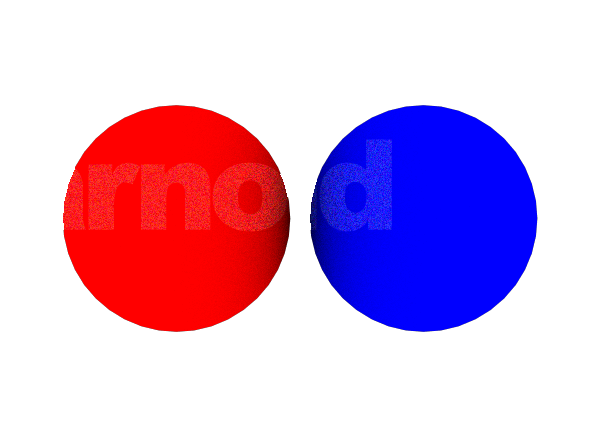

In [25]:
from IPython.display import Image
from pyvirtualdisplay import Display

IMAGE_WIDTH = 600
IMAGE_FILENAME = 'sphere-sample-Arnold.png'

try:
    display = Display(size=(IMAGE_WIDTH, IMAGE_WIDTH)).start()
    ! usdrecord \
        --complexity high \
        --imageWidth $IMAGE_WIDTH \
        --renderer Arnold \
        usd_data/sphere-sample.usda \
        $IMAGE_FILENAME > /dev/null 2>&1
finally:
    display.stop()

Image(IMAGE_FILENAME)